<a href="https://colab.research.google.com/github/qus0in/investment_study-2022/blob/main/220318_%EB%AF%B8%EA%B5%AD_%EB%A0%88%EB%B2%84%EB%A6%AC%EC%A7%80_ETF_%EC%83%81%EA%B4%80%EA%B4%80%EA%B3%84_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 미국 레버리지/인버스 ETF 간 상관관계 분석

## 설치

In [ ]:
# 주가 데이터 조회를 위한 야후 파이낸스 설치
# !를 통해 리눅스 명령어 사용 가능
!pip install yfinance

## 라이브러리

In [29]:
# 데이터 수집
import yfinance as yf # 야후 파이낸스
import requests # HTTP를 통한 데이터 요청
from bs4 import BeautifulSoup # 태그 데이터 파싱

# 데이터 처리
import pandas as pd # 판다스
from tqdm.notebook import tqdm # 진행율 시각화

# 데이터 시각화
import matplotlib.pyplot as plt
import seaborn as sns

## 클래스 구현
- 재활용성 향상 및 가독성 향상을 위해 클래스 사용
- 초기화와 동시에 데이터를 수집하고 필요한 데이터를 특정 키값만으로 바로 꺼내서 쓸 수 있는 방향으로 구현

In [81]:
# ETF DB(https://etfdb.com)에서 레버리지 ETF 종목코드(Symbol) 조회
# 해당 종목코드로 야후 파이낸스에서 종목 거래 시계열 데이터(historical data, ohlcv) 수집
class LeveragedETF:
    '''레버리지 ETF 데이터 수집 처리'''
    def __init__(self):
        # 데이터를 불러올 수 있는 URL
        self.url = "https://etfdb.com/data_set/"
        self.get_symbols()
        self.get_all_history()
    
    def get_parameters(self, page, size):
        '''HTTP 요청에 쓰일 Query Parameter 생성'''
        # page * size만큼 offset 전진 (size는 25로 예상)
        return {
            "tm": 77609, # 레버리지/인버스 필터링 코드
            "offset": (page - 1) * size,
            # 기본적으로 3개월 평균 거래량으로 정렬
            "sort": "three_month_average_volume",
            "order": "desc" # 내림차순 (큰 것이 먼저)
        }
    
    def get_symbols(self):
        '''ETF DB에서 종목조회에 필요한 코드 조회'''
        page, size = 1, 0 # 한 번에 전체 조회가 불가능하므로 page를 증가시키면서 조회해야함
        self.symbols = [] # 검색된 레버리지 코드들
        while True: # 계속 반복
            # print(f"page: {page} / symbols: {len(self.symbols)}")
            params = self.get_parameters(page, size) # 조회된 size만큼 전진해서 요청
            response = requests.get(self.url, params=params).json()
            # json 포맷으로 데이터 받아옴
            rows = response['rows'] # 받아온 데이터 요소들
            if len(rows) == 0: return self.symbols # 값이 없으면 반복 종료
            # 받은 데이터가 태그로 덮여있는데 BS로 태그 제거하고 텍스트만 남기기
            symbol_mapper = lambda x: BeautifulSoup(x['symbol']).text
            # 텍스트로 된 새로운 코드 리스트를 앞서 정의한 코드 리스트에 연결
            self.symbols.extend([symbol_mapper(r) for r in rows])
            size = len(rows) # 추가된 데이터만큼 다시 offset (25로 고정해도 됨)
            page+=1 # 다음 장으로
    
    def get_history(self, ticker, period="1y"):
        '''종목코드(Symbol? Ticker?)를 통해 특정 기간(기본 1년)의 종목 거래 데이터 조회'''
        # https://pypi.org/project/yfinance/
        return yf.Ticker(ticker).history(period)
        # 야후 파이낸스를 통해 조회, 패러미터를 통해 조회기간 조정 가능 (ex. 1mo)
    
    def get_all_history(self):
        '''앞서 찾아놓은 레버리지/인버스 ETF 코드들을 통해 일괄적으로 거래 데이터 수집'''
        self.all_history = [self.get_history(s) for s in tqdm(self.symbols)]
        return self.all_history

    def get_columns(self, column):
        '''수집한 전체 데이터에서 특정 행만 남겨서 결합'''
        df = pd.DataFrame()
        # tqdm -> 실제 데이터에는 영향미치지 않지만 진척도 확인 가능
        for i in tqdm(range(len(self.symbols))):
            # 모든 암호화폐 데이터에서 특정 행을 추출해서 결합 
            df[self.symbols[i]] = self.all_history[i][column]
        return df

In [ ]:
# ETF 초기화
etf = LeveragedETF()

## 데이터 처리 및 시각화
* 13일 종가 변동(단기 추세)의 상관 관계 분석
* 해당 기간 동안의 거래량 상위 25% 종목 추출 (37건)
* heatmap으로 시각화 [(참고)](https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=kiddwannabe&logNo=221205309816)

In [94]:
def filter_volume(days, quantile=.75):
    '''특정일 동안의 거래량을 하위 몇 %에서 끊을 것인가? + n일간의 데이터'''
    # n일 간 거래량 평균 구하기
    volume_days = etf.get_columns('Volume').tail(days).mean()
    # 13일선 거래량 평균이 상위 25% 이상인 종목 선택
    volume_screen = volume_days > volume_days.quantile(quantile)
    print(f"상위 {(1-quantile) * 100}% (하위 {quantile * 100}%) 거래량 : {volume_days.quantile(quantile)}")
    # 조건에 맞는 컬럼 선택
    # https://thispointer.com/pandas-select-columns-based-on-conditions-in-dataframe/
    close_screen = etf.get_columns('Close').loc[:, volume_screen]
    return close_screen.tail(days)

# 13일 거래량 상위 25%
filter_volume(13)

  0%|          | 0/183 [00:00<?, ?it/s]

상위 25.0% (하위 75.0%) 거래량 : 2642576.923076923


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


  0%|          | 0/183 [00:00<?, ?it/s]

,TQQQ,UVXY,SQQQ,SOXS,SOXL,SPXU,QID,SPXS,TZA,LABU,...,LABD,FAZ,JDST,NUGT,TECL,ERY,TMF,DUST,BULZ,YANG
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-18,42.695000,71.400002,70.949997,11.69,33.687225,24.900000,27.500000,32.930000,33.060001,90.680000,...,20.980000,33.630001,11.05,58.639999,38.684708,18.549999,21.259264,21.040001,NaN,12.930000
2021-03-19,43.240002,67.199997,70.050003,11.25,34.726524,25.020000,27.260000,33.130001,32.310001,99.089996,...,19.020000,34.790001,10.67,59.240002,38.206257,18.500000,21.608757,20.740000,NaN,12.950000
2021-03-22,45.544998,60.500000,66.250000,10.51,36.975006,24.420000,26.270000,32.349998,33.060001,103.620003,...,18.139999,36.080002,11.08,58.250000,40.528732,18.889999,22.307747,21.110001,NaN,12.940000
2021-03-23,44.950001,65.000000,67.150002,11.36,34.021721,24.990000,26.540001,33.070000,36.639999,85.769997,...,21.290001,37.680000,11.96,55.090000,39.751251,19.420000,22.952250,22.230000,NaN,13.830000
2021-03-24,42.680000,65.599998,70.500000,11.83,32.582073,25.400000,27.420000,33.580002,39.160000,72.470001,...,24.600000,37.299999,12.30,54.009998,38.315899,18.420000,23.281992,22.690001,NaN,15.370000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-11,42.340000,19.920000,48.540001,5.22,30.690001,16.980000,22.150000,22.410000,35.849998,13.660000,...,46.139999,22.170000,7.62,71.010002,46.119999,5.470000,20.959999,12.200000,10.26,36.209999
2022-03-14,39.860001,20.879999,51.389999,5.70,27.910000,17.379999,22.990000,22.920000,37.849998,11.860000,...,52.180000,21.559999,8.34,65.150002,43.500000,5.810000,19.559999,13.160000,9.28,43.700001
2022-03-15,43.549999,19.969999,46.639999,4.96,31.510000,16.209999,21.580000,21.430000,36.330002,12.370000,...,49.700001,20.719999,8.19,65.690002,47.880001,6.240000,19.400000,13.070000,10.38,43.910000


In [120]:
def draw_heatmap_by_corr(days, size=(32, 24)):
    '''상관관계 값을 통해 heatmap 그리기'''
    corr = filter_volume(days).corr() # 상관관계
    plt.figure(figsize=size) # 그래프 사이즈 (인치 단위)
    # Seaborn의 heatmap 기능을 활용하여 상관관계 표현
    # https://seaborn.pydata.org/generated/seaborn.heatmap.html
    sns.heatmap(
        # data = close13_corr.apply(abs), # 절대값 사용 시
        data = corr,
        annot= True, # 수치 표시 여부
        fmt = '.2f', # 수치 포맷
        linewidths=.2, # 구분선 굵기
        # https://seaborn.pydata.org/tutorial/color_palettes.html
        cmap='coolwarm', # 히트맵 색상
        center=0,
    )
    plt.title(f"{days}-Days Price Correlation", fontsize = 24, pad = 24) # 타이틀

  0%|          | 0/183 [00:00<?, ?it/s]

상위 25.0% (하위 75.0%) 거래량 : 2642576.923076923


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


  0%|          | 0/183 [00:00<?, ?it/s]

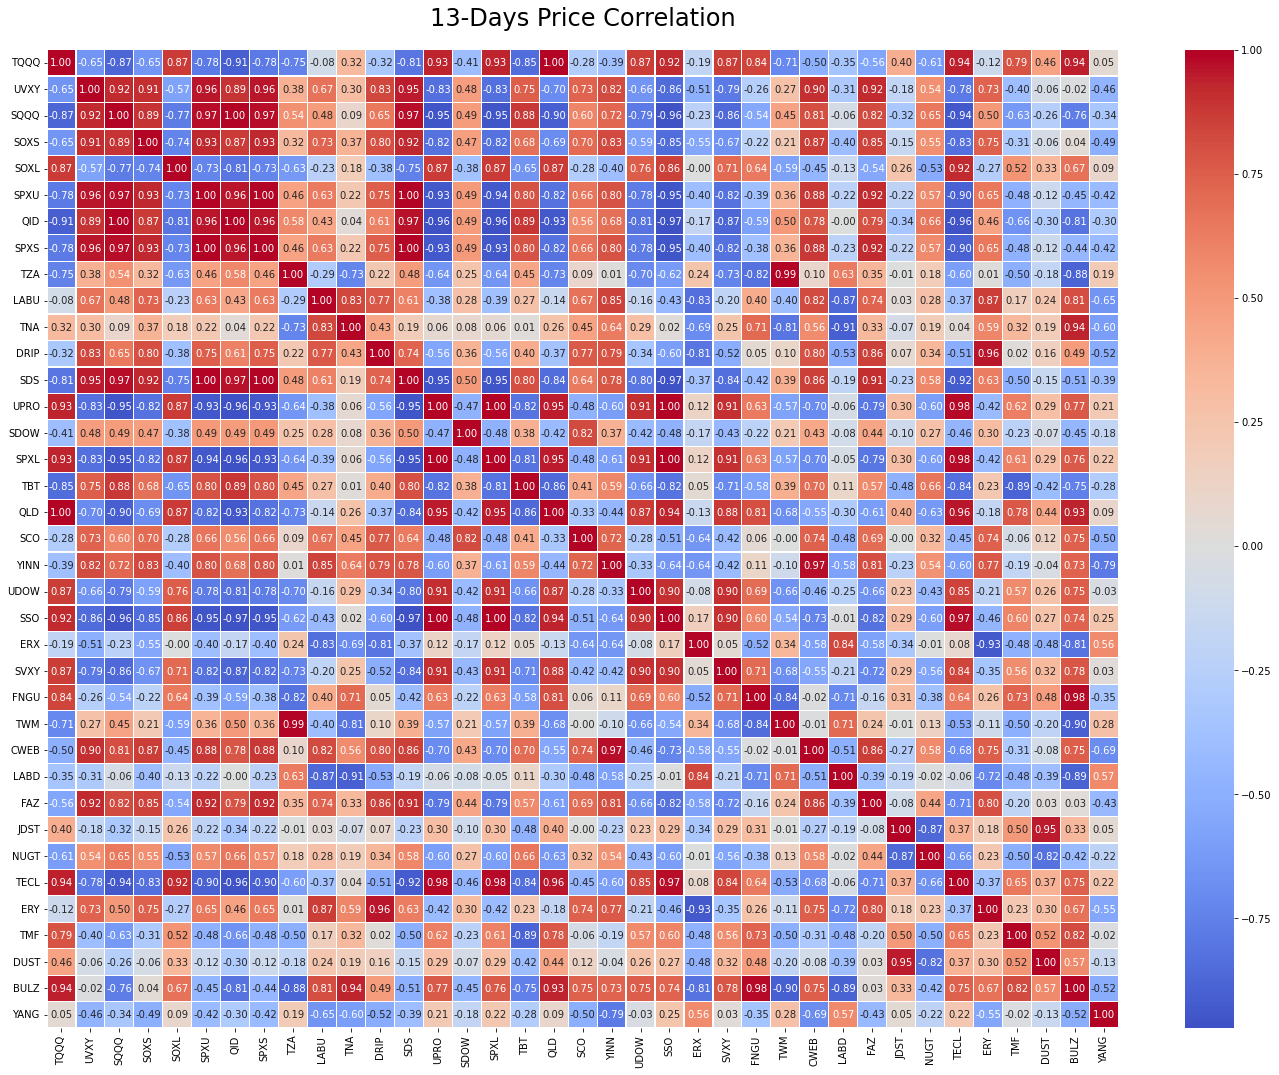

In [121]:
# 13일 간 상위 25% 거래량 종목 간 상관관계 (단기 추세)
draw_heatmap_by_corr(13, size=(24,18))